# Example: Random KS model (we just take any with Picard Rank 2)

In [1]:
# some general packages
import numpy as np
import os
import pickle

# ML packages
import tensorflow as tf

# data generation
from cymetric.pointgen.pointgen_mathematica import ToricPointGeneratorMathematica
from cymetric.pointgen.nphelper import prepare_dataset, prepare_basis_pickle
from cymetric.models.tfhelper import prepare_tf_basis, train_model

# training
from cymetric.models.tfmodels import PhiFSModelToric
from cymetric.models.callbacks import SigmaCallback, TransitionCallback, RicciCallback, VolkCallback
from cymetric.models.metrics import SigmaLoss, TransitionLoss, RicciLoss, VolkLoss
from cymetric.models.measures import sigma_measure, transition_measure_loss, ricci_measure

## Compute toric information

In [2]:
from cymetric.sage.sagelib import prepare_toric_cy_data

work_dir = "./ToricModel"
vertices = [[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1], [-1, -1, -1, 0], [2, 0, 0, -1]]  # P2 fibered over P2
polytope = LatticePolytope(vertices)
pConfig = PointConfiguration(polytope.points(), star=[0 for _ in range(len(vertices[0]))])
triangs = pConfig.restrict_to_connected_triangulations().restrict_to_fine_triangulations().restrict_to_regular_triangulations().restrict_to_star_triangulations([0 for _ in range(len(vertices[0]))]).triangulations_list()
triang = triangs[0]
tv_fan = triang.fan()
tv = ToricVariety(tv_fan)

toric_data = prepare_toric_cy_data(tv, os.path.join(work_dir, "toric_data.pickle"))
list(toric_data.keys())

ModuleNotFoundError: No module named 'sage'

## Generate points

In [5]:
work_dir = "./ToricModel"
with open(os.path.join(work_dir, 'toric_data.pickle'), 'rb') as f:
    toric_data = pickle.load(f)
num_pts       = int(50000)
precision     = int(10)
verbose       = int(1)
kmoduli       = np.ones(len(toric_data['exps_sections']))

In [6]:
mathematica_pointgen = ToricPointGeneratorMathematica(toric_data, kmoduli, precision=precision, verbose=verbose)

In [7]:
kappa = mathematica_pointgen.prepare_dataset(num_pts, work_dir)
prepare_basis_pickle(mathematica_pointgen, work_dir, kappa);

WolframKernel-<tcp://127.0.0.1:60550>:INFO:Connected to logging socket: tcp://127.0.0.1:60550
WolframKernel-<tcp://127.0.0.1:60550>:DEBUG:Evaluating a new expression.
pointgenMathematica:DEBUG:Running with 10 Mathematica kernels.
pointgenMathematica:DEBUG:Initializing generation of 50000 points...
WolframKernel-<tcp://127.0.0.1:60550>:INFO:Number of points on CY from one ambient space intersection: 4
WolframKernel-<tcp://127.0.0.1:60550>:INFO:Now generating 50000 points...
WolframKernel-<tcp://127.0.0.1:60550>:INFO:Generated 0% of points
WolframKernel-<tcp://127.0.0.1:60550>:INFO:Generated 5% of points
WolframKernel-<tcp://127.0.0.1:60550>:INFO:Generated 10% of points
WolframKernel-<tcp://127.0.0.1:60550>:INFO:Generated 15% of points
WolframKernel-<tcp://127.0.0.1:60550>:INFO:Generated 20% of points
WolframKernel-<tcp://127.0.0.1:60550>:INFO:Generated 25% of points
WolframKernel-<tcp://127.0.0.1:60550>:INFO:Generated 30% of points
WolframKernel-<tcp://127.0.0.1:60550>:INFO:Generated 35

old (50000, 6)
pm (50000,)
new (49999, 6)


WolframKernel-<tcp://127.0.0.1:60596>:INFO:Connected to logging socket: tcp://127.0.0.1:60596
WolframKernel-<tcp://127.0.0.1:60596>:DEBUG:Evaluating a new expression.
pointgenMathematica:DEBUG:Running with 10 Mathematica kernels.
pointgenMathematica:DEBUG:Initializing generation of 101 points...
WolframKernel-<tcp://127.0.0.1:60596>:INFO:Number of points on CY from one ambient space intersection: 4
WolframKernel-<tcp://127.0.0.1:60596>:INFO:Now generating 101 points...
WolframKernel-<tcp://127.0.0.1:60596>:INFO:Generated 0% of points
WolframKernel-<tcp://127.0.0.1:60596>:INFO:Generated 5% of points
WolframKernel-<tcp://127.0.0.1:60596>:INFO:Generated 10% of points
WolframKernel-<tcp://127.0.0.1:60596>:INFO:Generated 15% of points
WolframKernel-<tcp://127.0.0.1:60596>:INFO:Generated 20% of points
WolframKernel-<tcp://127.0.0.1:60596>:INFO:Generated 25% of points
WolframKernel-<tcp://127.0.0.1:60596>:INFO:Generated 30% of points
WolframKernel-<tcp://127.0.0.1:60596>:INFO:Generated 35% of

old (101, 6)
pm (101,)
new (101, 6)


## set up NN

load in data

In [16]:
tf.get_logger().setLevel('ERROR')
data = np.load(os.path.join(work_dir, 'dataset.npz'))
toric_data = np.load(os.path.join(work_dir, 'toric_data.pickle'), allow_pickle=True)
BASIS = prepare_tf_basis(np.load(os.path.join(work_dir, 'basis.pickle'), allow_pickle=True))

set up NN callbacks (info on training process)

In [17]:
scb = SigmaCallback((data['X_val'], data['y_val']))
rcb = RicciCallback((data['X_val'], data['y_val']), data['val_pullbacks'])
volkck = VolkCallback((data['X_val'], data['y_val']))
cb_list = [scb, volkck, rcb]

cmetrics = [SigmaLoss(), VolkLoss()]

define the NN hyperparameters (wrapping everything in int() and float() is necessary in sage)

In [18]:
nfold       = int(BASIS['NFOLD'].numpy().real)
amb         = [int(6)]
n_in        = int(12)
n_out       = int(1)
n_hiddens   = [int(64), int(64), int(64)]
acts        = ['gelu', 'gelu', 'gelu']
n_epochs    = int(30)
batch_sizes = [int(64), int(50000)]
alpha       = [float(1.), float(1.), float(1.), float(1.), float(5.)]

initialize the NN and the Toric Phi Model

In [19]:
model = tf.keras.Sequential()
model.add(tf.keras.Input(shape=(int(n_in))))
for n_hidden, act in zip(n_hiddens, acts):
    model.add(tf.keras.layers.Dense(n_hidden, activation=act))
model.add(tf.keras.layers.Dense(n_out, use_bias=False))

fs_model = PhiFSModelToric(model, BASIS, alpha=alpha, toric_data=toric_data)

## train NN

In [20]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '0'  # mostly silences TF logger
fs_model, training_history = train_model(fs_model, data, epochs=n_epochs, batch_sizes=batch_sizes,
                                         verbose=1, custom_metrics=cmetrics, callbacks=cb_list)


Epoch  1/30
 - Sigma measure val:      0.4997
 - Volk val:               19.2069
 - Ricci measure val:      7.3693
700/704 [============================>.] - ETA: 0s - sigma_loss: 0.3643 - volk_loss: 0.0000e+00 - Sigma measure val:      0.3800
 - Volk val:               13.6442
 - Ricci measure val:      6.4771
704/704 [==============================] - 17s 19ms/step - sigma_loss: 0.3641 - volk_loss: 0.0000e+00 - sigma_val: 0.3800 - volk_val: 13.6442 - ricci_val: 6.4771
 - Sigma measure val:      0.3800
 - Volk val:               13.6442
 - Ricci measure val:      6.4771
1/1 [==============================] - ETA: 0s - sigma_loss: 0.3110 - volk_loss: 6.0000 - Sigma measure val:      0.3806
 - Volk val:               13.3226
 - Ricci measure val:      6.6084
1/1 [==============================] - 15s 15s/step - sigma_loss: 0.3110 - volk_loss: 6.0000 - sigma_val: 0.3806 - volk_val: 13.3226 - ricci_val: 6.6084

Epoch  2/30
 - Sigma measure val:      0.3806
 - Volk val:               13.3


Epoch 10/30
 - Sigma measure val:      0.2597
 - Volk val:               16.8085
 - Ricci measure val:      6.4204
704/704 [==============================] - ETA: 0s - sigma_loss: 0.1973 - volk_loss: 0.0000e+00 - Sigma measure val:      0.2521
 - Volk val:               16.8245
 - Ricci measure val:      6.7453
704/704 [==============================] - 15s 18ms/step - sigma_loss: 0.1973 - volk_loss: 0.0000e+00 - sigma_val: 0.2521 - volk_val: 16.8245 - ricci_val: 6.7453
 - Sigma measure val:      0.2521
 - Volk val:               16.8245
 - Ricci measure val:      6.7453
1/1 [==============================] - ETA: 0s - sigma_loss: 0.1934 - volk_loss: 7.8968 - Sigma measure val:      0.2521
 - Volk val:               16.6029
 - Ricci measure val:      6.7408
1/1 [==============================] - 13s 13s/step - sigma_loss: 0.1934 - volk_loss: 7.8968 - sigma_val: 0.2521 - volk_val: 16.6029 - ricci_val: 6.7408

Epoch 11/30
 - Sigma measure val:      0.2521
 - Volk val:               16.6


Epoch 19/30
 - Sigma measure val:      0.2285
 - Volk val:               17.6931
 - Ricci measure val:      7.0394
700/704 [============================>.] - ETA: 0s - sigma_loss: 0.1651 - volk_loss: 0.0000e+00 - Sigma measure val:      0.2258
 - Volk val:               17.4153
 - Ricci measure val:      3.3294
704/704 [==============================] - 15s 18ms/step - sigma_loss: 0.1651 - volk_loss: 0.0000e+00 - sigma_val: 0.2258 - volk_val: 17.4153 - ricci_val: 3.3294
 - Sigma measure val:      0.2258
 - Volk val:               17.4153
 - Ricci measure val:      3.3294
1/1 [==============================] - ETA: 0s - sigma_loss: 0.1606 - volk_loss: 8.2895 - Sigma measure val:      0.2258
 - Volk val:               17.2385
 - Ricci measure val:      5.3426
1/1 [==============================] - 13s 13s/step - sigma_loss: 0.1606 - volk_loss: 8.2895 - sigma_val: 0.2258 - volk_val: 17.2385 - ricci_val: 5.3426

Epoch 20/30
 - Sigma measure val:      0.2258
 - Volk val:               17.2


Epoch 28/30
 - Sigma measure val:      0.2067
 - Volk val:               17.6793
 - Ricci measure val:      7.5506
701/704 [============================>.] - ETA: 0s - sigma_loss: 0.1473 - volk_loss: 0.0000e+00 - Sigma measure val:      0.2049
 - Volk val:               17.6238
 - Ricci measure val:      6.7866
704/704 [==============================] - 16s 19ms/step - sigma_loss: 0.1473 - volk_loss: 0.0000e+00 - sigma_val: 0.2049 - volk_val: 17.6238 - ricci_val: 6.7866
 - Sigma measure val:      0.2049
 - Volk val:               17.6238
 - Ricci measure val:      6.7866
1/1 [==============================] - ETA: 0s - sigma_loss: 0.1425 - volk_loss: 8.4455 - Sigma measure val:      0.2052
 - Volk val:               17.5705
 - Ricci measure val:      6.7535
1/1 [==============================] - 14s 14s/step - sigma_loss: 0.1425 - volk_loss: 8.4455 - sigma_val: 0.2052 - volk_val: 17.5705 - ricci_val: 6.7535

Epoch 29/30
 - Sigma measure val:      0.2052
 - Volk val:               17.5

Check the volume normailzation of our data

In [21]:
dets_fs = np.real(tf.linalg.det(fs_model.fubini_study_pb(tf.cast(data['X_train'], tf.float32))).numpy())
dets_cy = np.real(tf.linalg.det(fs_model(tf.cast(data['X_train'], tf.float32))).numpy())
weights, omegas = data['y_train'][:,-2], data['y_train'][:,-1]
vol_k_fs = np.mean(weights * dets_fs / omegas)
vol_k_cy = np.mean(weights * dets_cy / omegas)
print("Vol_K from triple intersection numbers at t1=t2=1:                ", toric_data['vol_j_norm'])
print("Vol_K from MC integration over FS metric in Kahler class t1=t2=1: ", np.round(vol_k_fs, 2))
print("Vol_K from MC integration over CY metric in Kahler class t1=t2=1: ", np.round(vol_k_cy, 2))

Vol_K from triple intersection numbers at t1=t2=1:                 20
Vol_K from MC integration over FS metric in Kahler class t1=t2=1:  20.01
Vol_K from MC integration over CY metric in Kahler class t1=t2=1:  17.83


... and look at the value of the Kahler potential

In [22]:
fs_model.get_kahler_potential(data['X_train'][:10])

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([0.2932871 , 0.44076732, 0.38761204, 0.6006561 , 0.3577083 ,
       0.53522736, 0.40158698, 0.43403587, 0.24459185, 0.28800538],
      dtype=float32)>

## Plot the results

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
sns.set_style("darkgrid")

Note that vol_k val should be constant (and equal to 20.0). So in this case, it is off by 15%)

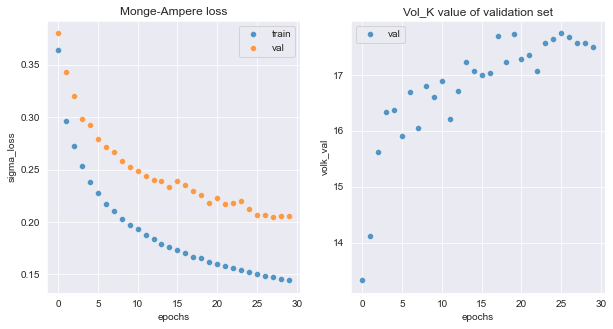

In [24]:
hist = training_history
hist['epochs'] = list(range(n_epochs))
hist_data = pd.DataFrame(hist)
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(10,5));
ax1.set_title("Monge-Ampere loss")
sns.scatterplot(x='epochs', y='sigma_loss', data=hist_data, alpha=0.75, ax=ax1, label="train")
sns.scatterplot(x='epochs', y='sigma_val', data=hist_data, alpha=0.75, ax=ax1, label="val")

ax2.set_title("Vol_K value of validation set")
sns.scatterplot(x='epochs', y='volk_val', data=hist_data, alpha=0.75, ax=ax2, label="val");